In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import numpy as np
from scipy.sparse.linalg import cg, lsqr
import matplotlib.pyplot as plt
import matplotlib.tri
import okada_wrapper
import tectosaur as tct

In [3]:
TCTN = 61
CURVE = 1.0

corners = [[-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, 0, 1]]
src_mesh = tct.make_rect(TCTN, TCTN, corners)
src_mesh[0][:,1] = CURVE * np.abs(src_mesh[0][:,0])
src_mesh[0][:,1] = CURVE * (src_mesh[0][:,0] ** 2 + src_mesh[0][:,2] ** 2)
def gauss_slip_fnc(x, z):
    r2 = x ** 2 + z ** 2
    R = 0.5
    out = (np.cos(np.sqrt(r2) * np.pi / R) + 1) / 2.0
    out[np.sqrt(r2) > R] = 0.0
    return out
dof_pts = src_mesh[0][src_mesh[1]]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((src_mesh[1].shape[0], 3, 3)).astype(np.float32)
slip[:,:,0] = gauss_slip_fnc(x, z)

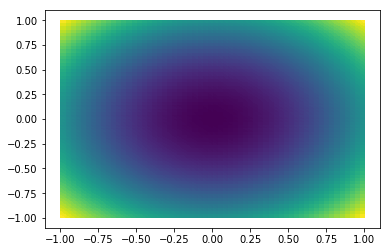

In [4]:
plt.tripcolor(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1], src_mesh[0][:,1])
plt.show()

In [5]:
H = tct.RegularizedSparseIntegralOp(
    6, 6, 6, 2, 5, 2.5,
    'elasticRH3', 'elasticRH3', [1.0, 0.25], src_mesh[0], src_mesh[1], np.float32,
    farfield_op_type = tct.TriToTriDirectFarfieldOp
)

[4462:DEBUG:tectosaur.util.gpu]
    start compiling assemble.cl
[4559:INFO:tectosaur.util.opencl]
    initializing opencl context with devices = ['Intel(R) Core(TM) i7-7600U CPU @ 2.80GHz']
[4589:DEBUG:tectosaur.util.gpu]
     compile took 0.12687224801629782
[4591:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[4596:DEBUG:tectosaur.nearfield.nearfield_op]
         setup pairs integrator took 0.25346418895060197
[6633:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident took 2.0358794539934024
[6655:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident correction took 0.021383700019214302
[6851:DEBUG:tectosaur.nearfield.nearfield_op]
         Find nearfield/adjacency took 0.19544519996270537
[13691:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent took 6.839981079043355
[13717:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent correction took 0.024918414012063295
[22027:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert ad

In [135]:
traction_mass_op = tct.MassOp(4, src_mesh[0], src_mesh[1])

In [136]:
dof_pts = src_mesh[0][src_mesh[1]]
from tectosaur.util.geometry import unscaled_normals
ns = unscaled_normals(dof_pts)
ns /= np.linalg.norm(ns, axis = 1)[:, np.newaxis]
ns = np.repeat(ns, 3, axis = 0)

In [137]:
edge_dofs = tct.free_edge_dofs(src_mesh[1], tct.find_free_edges(src_mesh[1]))

In [138]:
obs_pts = dof_pts.reshape((-1,3))[edge_dofs]
obs_ns = ns[edge_dofs]
interior_op = tct.InteriorOp(obs_pts.copy(), obs_ns.copy(), src_mesh, 'elasticH3', 4.0, 10, 6, 6, [1.0, 0.25], np.float32)

[1247578:DEBUG:tectosaur.util.gpu]
    returning cached gpu module matrix_free.cl
[1247598:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1247633:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1247697:DEBUG:tectosaur.util.gpu]
    start compiling interior_corners.cl
[1247707:DEBUG:tectosaur.util.gpu]
     compile took 0.010870789003092796


In [139]:
trac_edges = -interior_op.dot(slip.flatten())

In [140]:
vec_edge_dofs = np.tile(3 * np.array(edge_dofs)[:,np.newaxis], (1,3))
vec_edge_dofs[:,1] += 1
vec_edge_dofs[:,2] += 2
vec_edge_dofs = vec_edge_dofs.flatten()

In [141]:
cs = tct.continuity_constraints(src_mesh[0], src_mesh[1], src_mesh[1].shape[0])
cs.extend(tct.simple_constraints(vec_edge_dofs, trac_edges))
cmU, _, _ = tct.build_constraint_matrix(cs, src_mesh[1].shape[0] * 9)

In [203]:
csT1, csT2 = tct.traction_admissibility_constraints(src_mesh[0], src_mesh[1])
csT1.extend(tct.simple_constraints(vec_edge_dofs, trac_edges))
cmT, c_rhs, _ = tct.build_constraint_matrix(csT1, src_mesh[1].shape[0] * 9)

In [199]:
rows = []
cols = []
data = []
for i in range(len(csT2)):
    c = csT2[i]
    for j in range(len(c.terms)):
        rows.append(i)
        cols.append(c.terms[j].dof)
        data.append(c.terms[j].val)

In [200]:
import scipy.sparse
cmT2 = scipy.sparse.csr_matrix((data, (rows, cols)), shape = (len(csT2), cmT.shape[0]))

In [196]:
constrained_traction_mass_op = cmU.T.dot(traction_mass_op.mat.dot(cmT))
full_lhs = scipy.sparse.vstack((constrained_traction_mass_op, cmT2.dot(cmT)))
full_rhs = np.concatenate((rhs, np.zeros(cmT2.shape[0])))

In [204]:
full_lhs.shape, full_rhs.shape, cmT.shape, cmU.shape, cmT2.shape, constrained_traction_mass_op.shape

((35283, 41772),
 (35283,),
 (64800, 41772),
 (64800, 10443),
 (24840, 64800),
 (10443, 41772))

In [185]:
rhs = -cmU.T.dot(H.dot(slip.flatten())) - cmU.T.dot(traction_mass_op.mat.dot(c_rhs))
#soln = cg(constrained_traction_mass_op, rhs)
soln = lsqr(full_lhs, full_rhs)
out = cmT.dot(soln[0]) + c_rhs

[1775617:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1776658:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 1.0415672459930647
[1776659:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1776708:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.049151234998134896


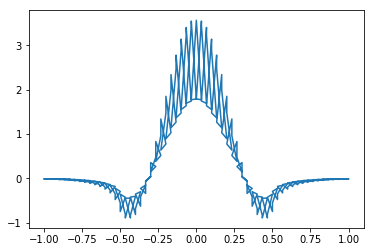

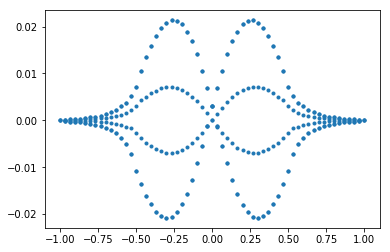

In [191]:
pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,2]) < 0.01)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.plot(pts[idxs][:,0], out.reshape((-1,3))[idxs][:,0])
plt.show()
pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.plot(pts[idxs][:,2], out.reshape((-1,3))[idxs][:,2], '.')
plt.show()

/home/tbent/.virtualenvs/tectosaur/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


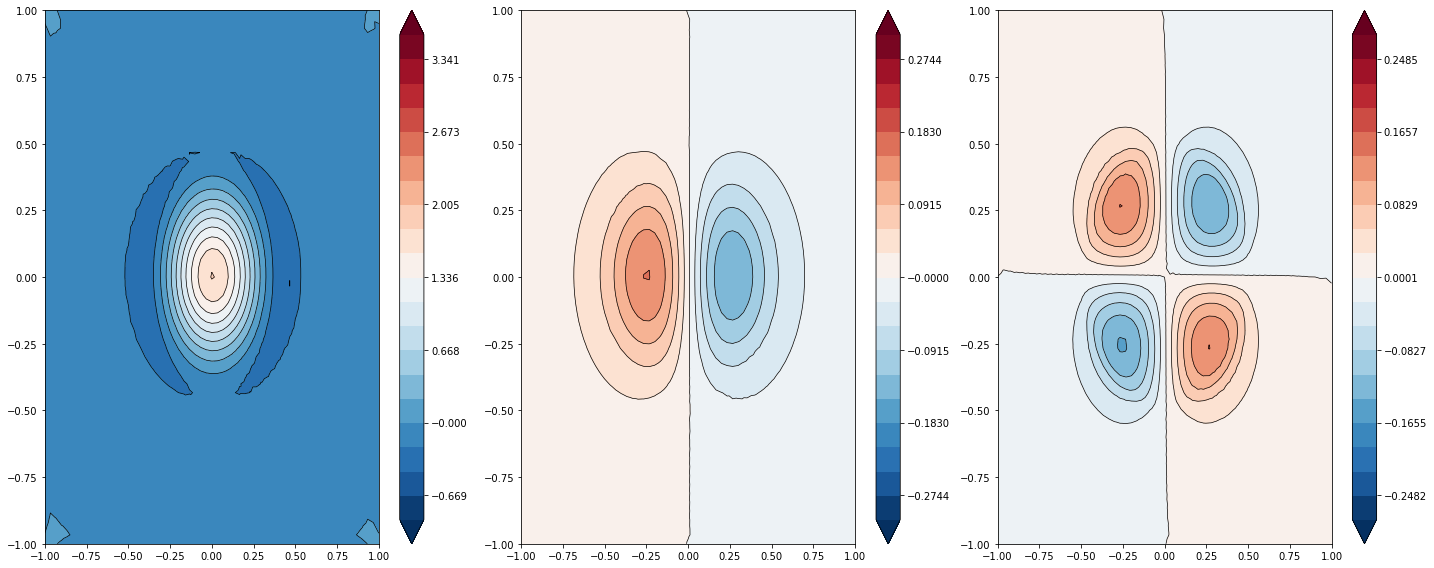

In [188]:
levels = []
for d in range(3):
    minf = np.min(out.reshape((-1,3))[:,d])
    maxf = np.max(out.reshape((-1,3))[:,d])
    levels.append(np.linspace(minf - 1e-12, maxf + 1e-12, 21))
#levels[2] = np.linspace(-0.15, 0.15, 11)
# levels = [
#     np.linspace(-0.1, 0.6, 21),
#     np.linspace(-1.9, 1.9, 21),
#     np.linspace(-0.2, 0.2, 21)
# ]
tri_centers = np.mean(src_mesh[0][src_mesh[1]], axis = 1)
side = np.zeros(src_mesh[1].shape[0]).astype(np.int)
#side[tri_centers[:,0] > 0] = 1
n_sides = 1

cmap = 'RdBu_r'
plt.figure(figsize = (20,8))
for d in range(3):
    plt.subplot(1,3,d+1)
    field = out.reshape((-1,3,3))[:,:,d]
    for i in range(n_sides):
        which_tris = np.where(side == i)[0]
        reduced_m = tct.mesh.modify.remove_unused_pts((src_mesh[0], src_mesh[1][which_tris]))
        soln_vals = np.empty(reduced_m[0].shape[0])
        soln_vals[reduced_m[1]] = field[which_tris]
        cntf = plt.tricontourf(
            reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
            cmap = cmap, linewidth = 0.5, levels = levels[d], extend = 'both'
        )
        plt.tricontour(
            reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
            linestyles = 'solid', colors='k', linewidths = 0.7, levels = levels[d]
        ) 
    plt.colorbar(cntf)
    plt.tight_layout()
plt.show()

In [18]:
# for i in range(10):
#     C1 = cs12[i]
#     C2 = cs1[i]
#     print((C1.terms[0].dof, C1.terms[0].val), (C1.terms[1].dof, C1n.terms[1].val))
#     print((C2.terms[0].dof, C2.terms[0].val), (C2.terms[1].dof, C2.terms[1].val))

# plt.plot(obs_pts[:,0], trac_edges.reshape((-1,3))[:,0], '.')
# plt.show()

In [19]:
# def plot_fnc(triang, f):
#     levels = np.linspace(-np.max(f) - 1e-12, np.max(f) + 1e-12, 9)
#     #levels = np.linspace(-0.2, 0.2, 31)
#     cntf = plt.tricontourf(triang, f, levels = levels, cmap = 'RdBu_r')
#     #plt.tricontour(triang, f, levels = levels, linestyles = 'solid', colors = 'k', linewidths = 0.5)
#     plt.colorbar(cntf)

# triang = matplotlib.tri.Triangulation(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1])
# plt.figure(figsize = (25,8))
# for d in range(3):
#     f = out.reshape((-1,3,3))[:,:,d]
#     f_pts = np.zeros(src_mesh[0].shape[0])
#     f_pts[src_mesh[1]] = f
#     plt.subplot(1, 3, d + 1)
#     plot_fnc(triang, f_pts)
# plt.show()